In [14]:
import math
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [15]:
import os
path='C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/'

names=["YODA","LUKE SKYWALKER","R2-D2","MACE WINDU","GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [16]:
if not os.path.isdir(path+ 'train/'):
    for name in names:
        os.makedirs(path+'train/'+ name)
        os.makedirs(path+'val/'+ name)
        os.makedirs(path+'test/'+ name)

In [18]:

# Total number of classes in the datset

orig_folders=["0001/","0002/","0003/","0004/","0005/"]

for folder_idx, folder in enumerate(orig_folders):
    files=os.listdir(path+folder)
    no_of_images=len([name for name in files])
    n_train=int((no_of_images*0.6)+0.5)
    n_valid=int((no_of_images*0.25)+0.5)
    n_test=no_of_images-n_train-n_valid
    print(no_of_images,n_train,n_test,n_valid)
    for idx, file in enumerate(files):
        file_name=path+folder+file
        if idx<n_train:
            shutil.move(file_name,path+'train/'+names[folder_idx])
        elif idx<n_train+n_valid:
            shutil.move(file_name,path+'val/'+names[folder_idx])
        else:
            shutil.move(file_name,path+'test/'+names[folder_idx])

12 7 2 3
12 7 2 3
12 7 2 3
13 8 2 3
14 8 2 4


In [20]:
# Generate batches of tensor image data with real time data augmentation.
# preprocessing functions
# rescale=1./255 ->(0,1)


train_gen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [21]:
valid_gen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [26]:
train_batches=train_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/train',
    target_size=(256,256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names    
)
val_batches=valid_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/val',
    target_size=(256,256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names    
)
test_batches=test_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/test',
    target_size=(256,256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    classes=names    
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [28]:
train_batch=train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch=test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[3. 2. 2. 4.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


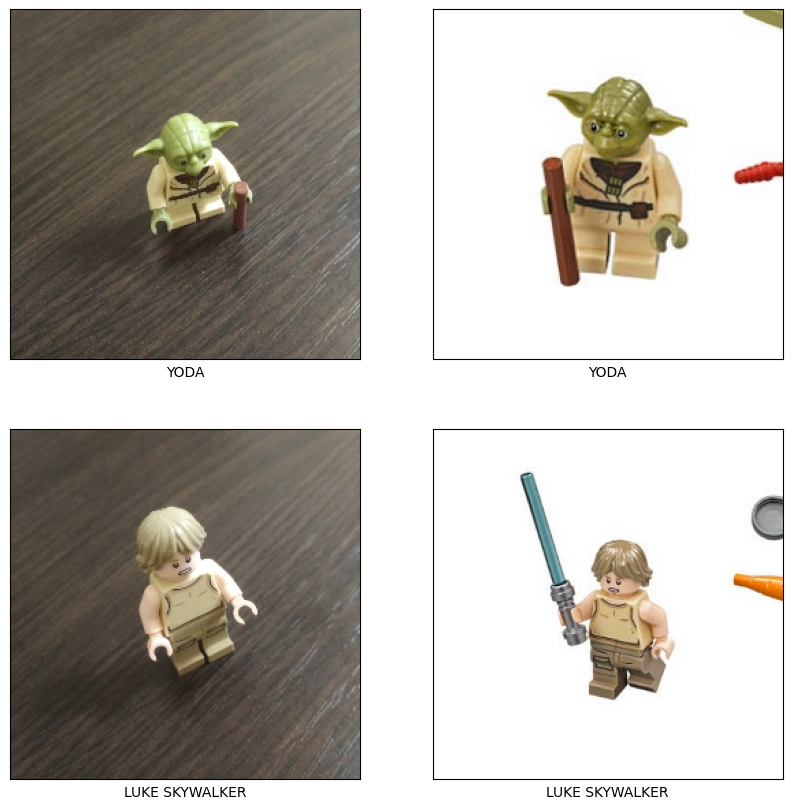

In [29]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

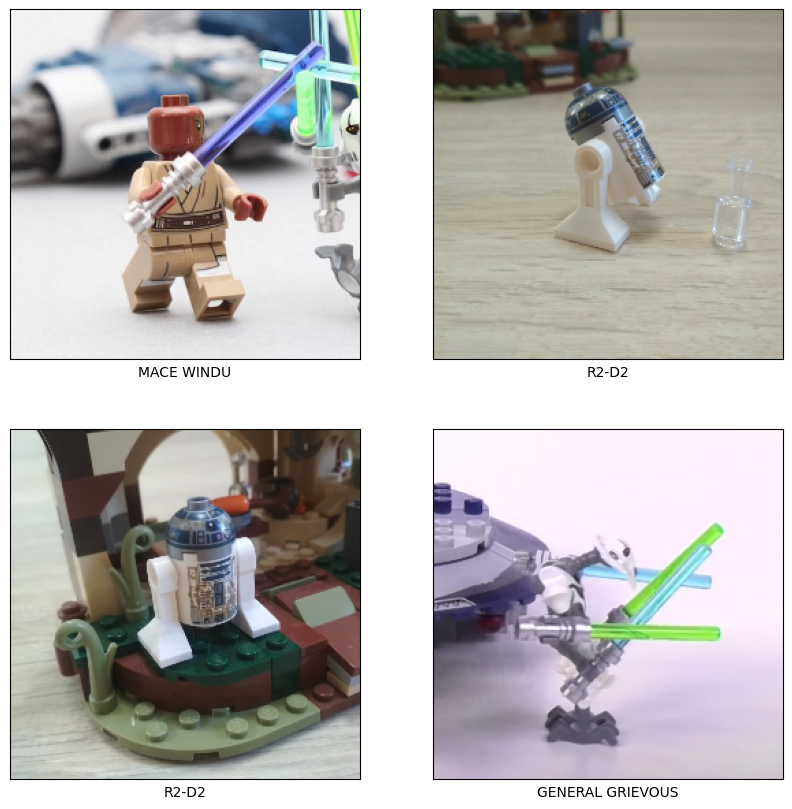

In [31]:
show(train_batch)

In [36]:
model=keras.models.Sequential()
model.add(layers.Input(shape=(256,256,3)))
model.add(layers.Conv2D(32,(3,3),
                        strides=(1,1),
                       padding="valid",
                       activation='relu'
                       ))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,764,805 (60.14 MB)

 Trainable params: 15,764,805 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# loss and optimzer

loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim=keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [39]:
# Training

# Early Callbacks
early_stopping=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history=model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[early_stopping],
    epochs=30,
    verbose=2
)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
10/10 - 11s - 1s/step - accuracy: 0.2432 - loss: 6.4263 - val_accuracy: 0.1875 - val_loss: 1.6970
Epoch 2/30
10/10 - 5s - 498ms/step - accuracy: 0.1892 - loss: 1.6147 - val_accuracy: 0.1875 - val_loss: 1.6757
Epoch 3/30
10/10 - 4s - 435ms/step - accuracy: 0.2973 - loss: 1.5856 - val_accuracy: 0.2500 - val_loss: 1.5628
Epoch 4/30
10/10 - 4s - 396ms/step - accuracy: 0.5135 - loss: 1.3377 - val_accuracy: 0.2500 - val_loss: 1.4871
Epoch 5/30
10/10 - 3s - 346ms/step - accuracy: 0.7297 - loss: 0.8931 - val_accuracy: 0.6250 - val_loss: 1.3070
Epoch 6/30
10/10 - 4s - 366ms/step - accuracy: 0.9189 - loss: 0.4668 - val_accuracy: 0.5625 - val_loss: 1.1474
Epoch 7/30
10/10 - 4s - 382ms/step - accuracy: 0.7297 - loss: 0.8816 - val_accuracy: 0.1875 - val_loss: 2.9505
Epoch 8/30
10/10 - 4s - 394ms/step - accuracy: 0.8378 - loss: 0.4848 - val_accuracy: 0.4375 - val_loss: 1.2820
Epoch 9/30
10/10 - 4s - 371ms/step - accuracy: 0.8919 - loss: 0.2559 - val_accuracy: 0.4375 - val_loss: 1.8593
Epo

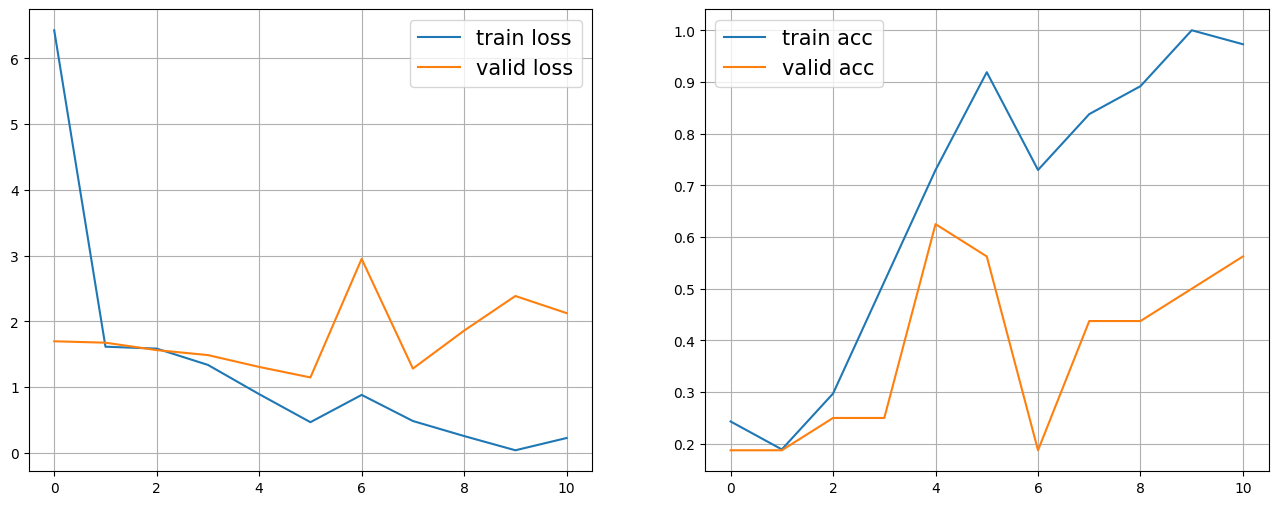

In [40]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [42]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - 69ms/step - accuracy: 0.7000 - loss: 0.5221


[0.5220857858657837, 0.699999988079071]

In [43]:
predictions= model.predict(test_batches)
predictions= tf.nn.softmax(predictions)
labels=np.argmax(predictions, axis=1)
print(test_batches[0][1])
print(labels[0:4])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[0. 0. 1. 1.]
[1 3 1 1]


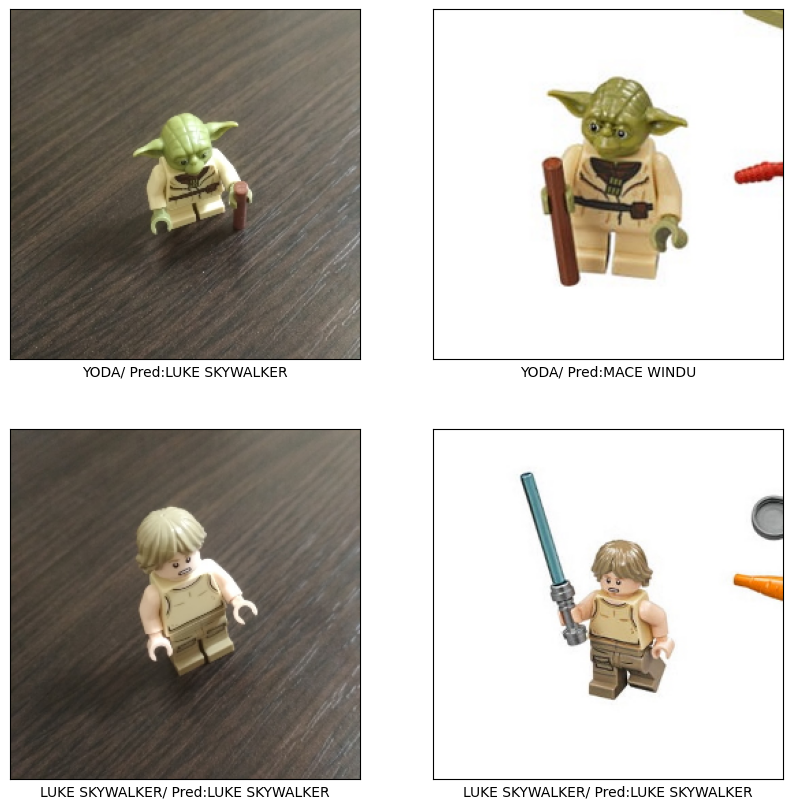

In [45]:
show(test_batches[0],labels[0:4])

    Transfer Learning

In [46]:
# Using Visual Geometry Group(VGG16) model

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

vgg_model=tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 146s 0us/step
<class 'keras.src.models.functional.Functional'>


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# convert the sequential model, omit the last layer
model = keras.models.Sequential()

# Loop through all layers of VGG16 except the very last 1000-class output layer
for layer in vgg_model.layers[:-1]:
    model.add(layer)


In [70]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [71]:
# Freeze the weights so we only train the new final layer
for layer in model.layers:
    layer.trainable = False

In [72]:
from tensorflow.keras import layers

model.add(layers.Dense(5))

In [73]:
# loss and optimizer


loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim=keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]

model.compile(loss=loss,optimizer=optim,metrics=metrics)

In [74]:
preprocess_input=tf.keras.applications.vgg16.preprocess_input

In [75]:
# generate batches of tensor image data with real time augmentation

train_gen=keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen=keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen=keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches=train_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/train',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    # classes=name
)

test_batches=test_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/test',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    # classes=name
)

valid_batches=valid_gen.flow_from_directory(
    'C:/Users/hp/Desktop/JN/lego-minifigures-classification/versions/30/star-wars/val',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode='rgb',
    # classes=name
)

Found 37 images belonging to 5 classes.
Found 10 images belonging to 5 classes.
Found 16 images belonging to 5 classes.


In [79]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=valid_batches,
          callbacks=[early_stopping],
          epochs=30, verbose=2)

Epoch 1/30
10/10 - 16s - 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8750 - val_loss: 0.1789
Epoch 2/30
10/10 - 16s - 2s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8750 - val_loss: 0.1823
Epoch 3/30
10/10 - 17s - 2s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8750 - val_loss: 0.1860
Epoch 4/30
10/10 - 15s - 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8750 - val_loss: 0.1887
Epoch 5/30
10/10 - 17s - 2s/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8750 - val_loss: 0.1928
Epoch 6/30
10/10 - 15s - 2s/step - accuracy: 1.0000 - loss: 9.7209e-04 - val_accuracy: 0.8750 - val_loss: 0.1949
Epoch 6: early stopping


In [80]:
test_loss, test_accuracy = model.evaluate(test_batches, verbose=2)

3/3 - 3s - 1s/step - accuracy: 0.9000 - loss: 0.3656


In [82]:
def deprocess_vgg16(x):
    """
    Reverses the VGG16 preprocessing (mean subtraction and BGR->RGB flip).
    """
    # Create a copy so we don't modify the original batch data
    x = x.copy()
    
    # 1. Add back the ImageNet mean values (standard BGR means)
    # VGG16 subtracts: [103.939, 116.779, 123.68]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 2. Reverse color channels: BGR back to RGB
    # This is done by flipping the last axis
    x = x[:, :, ::-1]
    
    # 3. Clip the values to ensure they stay within [0, 255]
    # Then convert to uint8 (standard image format)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


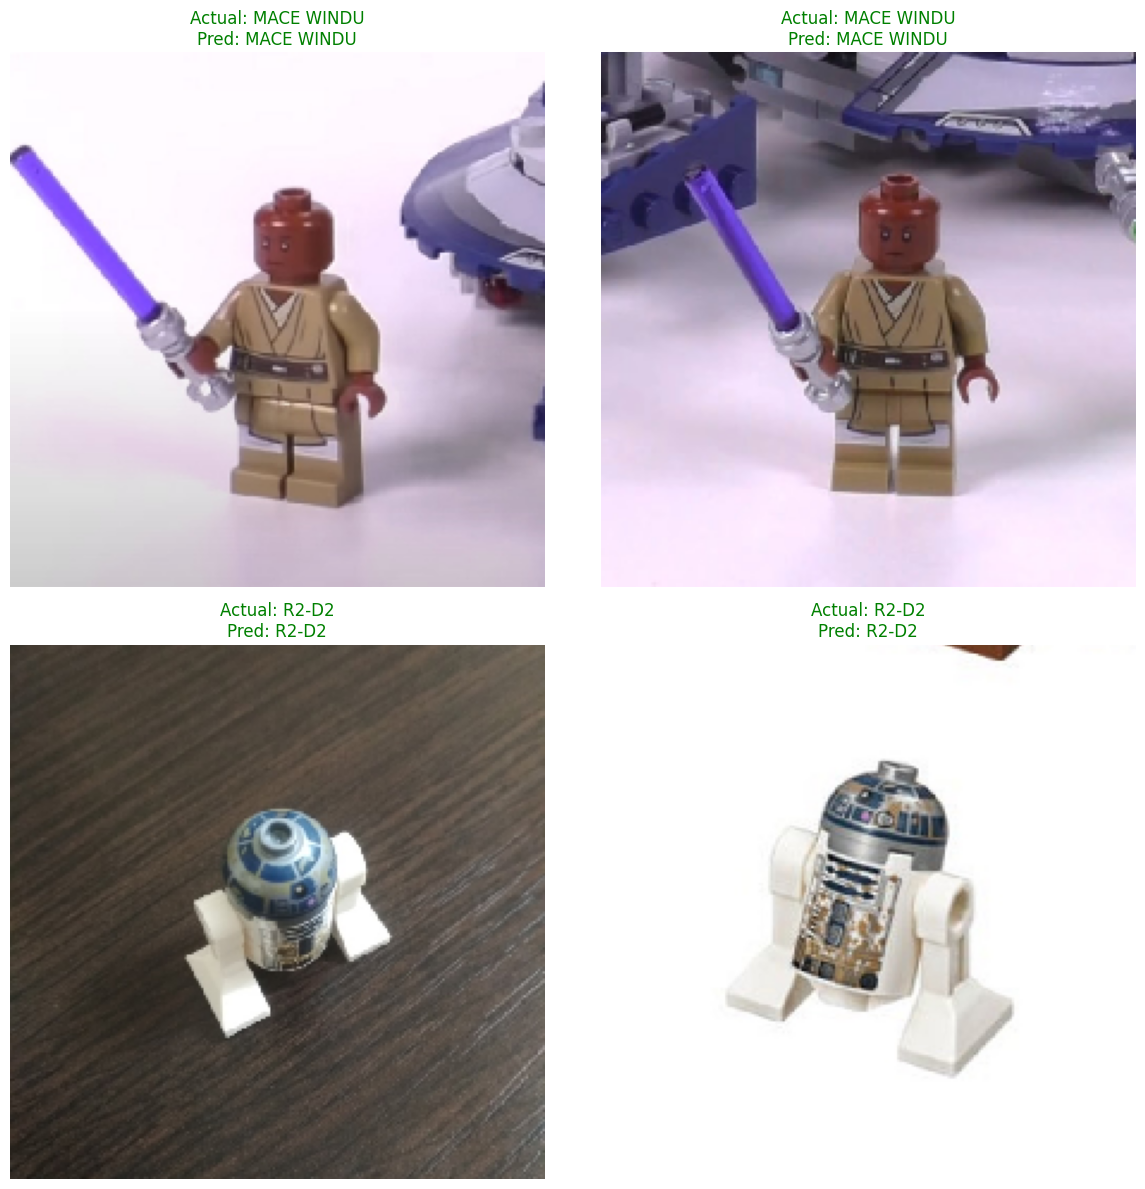

In [83]:
# --- Plotting and Prediction Logic ---

# 1. Grab a fresh batch of test images
# Using .next() gives us (images, labels)
test_images, test_labels = next(test_batches)

# 2. Get the model's predictions
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

# 3. Get the folder names (class names)
class_names = list(test_batches.class_indices.keys()) 

# 4. Create the plot grid
plt.figure(figsize=(12, 12))

# We loop through the batch (which was set to 4 in your code)
for i in range(len(test_images)):
    plt.subplot(2, 2, i+1)
    
    # Deprocess the image for viewing
    original_view = deprocess_vgg16(test_images[i])
    plt.imshow(original_view)
    
    # Check if prediction was correct to choose label color
    is_correct = pred_labels[i] == int(test_labels[i])
    color = 'green' if is_correct else 'red'
    
    plt.title(f"Actual: {class_names[int(test_labels[i])]}\nPred: {class_names[pred_labels[i]]}", 
              color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()